In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

!pip install --quiet efficientnet

import math, re
import numpy as np 
import pandas as pd
from sklearn.model_selection import KFold
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, Model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_datasets as tfds
from kaggle_datasets import KaggleDatasets
from functools import partial
import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

K = keras.backend
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
EPOCHS_SCL = 15
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
IMG_SIZE = 512
HEIGHT, WIDTH = 512, 512
CHANNELS = 3
N_FOLDS = 5
FOLDS_TO_USE = 3
# Create a generator
SEED = 42
GEN = tf.random.Generator.from_seed(SEED, alg='philox')
N_CLASSES = 101
# set mixed precision policy
POLICY = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_policy(POLICY)
# XLA
tf.config.optimizer.set_jit(True)

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


In [2]:
# Take note of the GCS path
data_dir = KaggleDatasets().get_gcs_path('food101-tfrecords')

TRAINING_FILENAMES = tf.io.gfile.glob(data_dir + '/train*/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(data_dir + '/valid/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(data_dir + '/test/*.tfrec')

In [3]:
class_items = open('../input/food101-tfrecords/classes.txt', 'r').readlines()
CLASSES = [item.rstrip('\n') for item in class_items]

In [4]:
def plot_transfomed_images(dataset):
    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in dataset.unbatch().take(9):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(tf.cast(image * 255.0, tf.uint8))
        label = tf.cast(label, tf.int32)
        plt.title("Class: {} \nShape: {}".format(CLASSES[label], image.shape))
        plt.axis("off")
    plt.show()
    
# plot some training statistics
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

def plot_conf_matrix(y_target, y_predicted):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    conf_matrix = confusion_matrix(y_target, y_predicted, labels=range(N_CLASSES))
    conf_matrix = (conf_matrix.T / conf_matrix.sum(axis=1)).T
    conf_matrix_df = pd.DataFrame(conf_matrix, index=CLASSES, columns=CLASSES)
    ax = sns.heatmap(conf_matrix_df, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('OOF', fontsize=30)
    plt.show()

In [5]:
# decode image
def decode_image(image_data):
    return tf.io.decode_jpeg(image_data, channels=3)
    
# standardize image size + central crop
def resize_and_crop(image):
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)
    return tf.image.central_crop(image, central_fraction=0.9)

# rescale images to [0, 1] range + resize & reshape to the expected size
def rescale_and_prepare(image):
    image = tf.cast(image, tf.float32)
    image /= 255.0 # range [0, 1]; range [-1, 1]: image = (image - 128.) / 128.
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image
    
# read labeled tfrecord
def read_tfrec(example, labeled=True):
    TFREC_FORMAT = (
        {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        }
        if labeled 
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['label'], tf.float32)
        return image, label
    return image

# create dataset
def load_dataset(filenames, labeled=True, ordered=False):
    # read from TFRecords. For optimal performance disregard data order
    # and read from multiple files simultaneously
    order = tf.data.Options()
    order.experimental_deterministic = False
    if ordered:
        order.experimental_deterministic = True
    dataset = tf.data.TFRecordDataset(filenames, 
                                      num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(order)
    dataset = dataset.map(
        partial(read_tfrec, labeled=labeled), 
        num_parallel_calls=AUTOTUNE)
    return dataset
    
# augmentation
def augment(image, batch_size=BATCH_SIZE):
    # Make a new seed
    seed = GEN.make_seeds(2)[0]
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]

    # Random flip
    image = tf.image.stateless_random_flip_left_right(image, new_seed)
    return image

# configure datasets for performance
def get_dataset(filenames, ordered=False, repeated=False, batch_size=BATCH_SIZE,  
                labeled=True, augmentation=False, shuffle=False, cached=False):
    # load dataset by filepaths
    ds = load_dataset(filenames, labeled=labeled, ordered=ordered)
    
    # standardize dataset
    ds = ds.map(lambda x, y: (resize_and_crop(x), y), 
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(2048)
        
    # the training dataset must repeat for several epochs
    if repeated:
        ds = ds.repeat()
        
    # vectorize transformations
    ds = ds.batch(batch_size, drop_remainder=True)
    
    # augment training dataset
    if augmentation:
        ds = ds.map(lambda x, y: (augment(x), y),
                    num_parallel_calls=AUTOTUNE)
    
    # prepare dataset
    ds = ds.map(lambda x, y: (rescale_and_prepare(x), y), 
                num_parallel_calls=AUTOTUNE)
    
    # cache dataset
    if cached:
        ds = ds.cache()

    # overlap producer and consumer works
    return ds.prefetch(AUTOTUNE)

train_set = get_dataset(TRAINING_FILENAMES, repeated=True, augmentation=True, shuffle=True)
valid_set = get_dataset(VALIDATION_FILENAMES, ordered=True, cached=True)
test_set = get_dataset(TEST_FILENAMES)

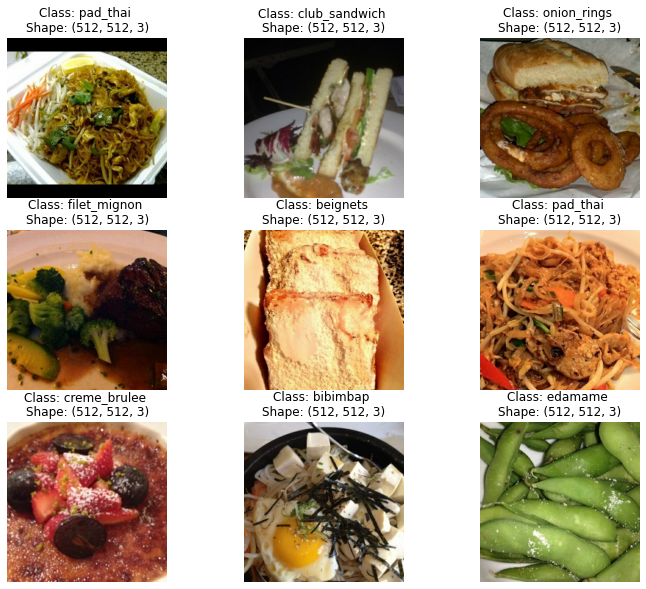

In [6]:
# visualize some data
plot_transfomed_images(train_set)

In [7]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, 
                                                                                 NUM_VALIDATION_IMAGES, 
                                                                                 NUM_TEST_IMAGES))

Dataset: 60600 training images, 15150 validation images, 25250 test images


In [8]:
def build_model(input_shape, N_CLASSES):
    # define model architecture & load pretrained weights
    base_model = efn.EfficientNetB4(input_shape=input_shape, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    # build top layers
    dropout1 = keras.layers.Dropout(.5)(base_model.output)
    dense = keras.layers.Dense(1000, activation="relu")(dropout1)
    dropout2 = keras.layers.Dropout(.5)(dense)
    output = keras.layers.Dense(N_CLASSES, activation="softmax", dtype='float32')(dropout2)
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
    return model

In [9]:
LR_START = 1e-6
LR_MAX = 3e-5 * strategy.num_replicas_in_sync
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8 

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
# define mode
with strategy.scope():
    model = build_model((None, None, 3), N_CLASSES)

history = model.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, 
                    validation_data=valid_set, validation_steps=VALIDATION_STEPS, 
                   callbacks=[lr_callback])

In [ ]:
model.evaluate(test_set, steps=TEST_STEPS)

# Augmentation

In [10]:
# decode image
def decode_image(image_data):
    image = tf.io.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])

def get_matrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """Returns 3x3 transformation matrix which then transforms indices"""
    # degrees to radians
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # rotation matrix
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(
        tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0), [3, 3])
    
    # shear matrix
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(
        tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0), [3, 3])
    
    # zoom matrix
    zoom_matrix = tf.reshape(
        tf.concat([one/height_zoom, zero, zero, zero, one/width_zoom, zero, zero, zero, one], axis=0), [3, 3])
    
    # shift matrix
    shift_matrix = tf.reshape(
        tf.concat([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis=0), [3, 3])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def augment(image):
    """Input: image of shape [height, width, 3], output: transformed image"""
    D = IMG_SIZE
    XD = D % 2
    
    rotation = 15. * tf.random.normal([1], dtype='float32')
    shear = 5. * tf.random.normal([1], dtype='float32')
    h_zoom = 1. + tf.random.normal([1], dtype='float32') / 10.
    w_zoom = 1. + tf.random.normal([1], dtype='float32') / 10.
    h_shift = 16. * tf.random.normal([1], dtype='float32')
    w_shift = 16. * tf.random.normal([1], dtype='float32')
    
    # transformation matrix
    M = get_matrix(rotation, shear, h_zoom, w_zoom, h_shift, w_shift)
    
    # destination pixel indices !!!!
    x = tf.repeat(tf.range(D//2, -D//2, -1), D)
    y = tf.tile(tf.range(-D//2, D//2), [D])
    z = tf.ones([D * D], dtype='int32')
    idx = tf.stack([x, y, z])
    
    # rotate destination pixels onto origin pixels !!!
    idx2 = K.dot(M, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -D//2 + XD + 1, D//2)
    
    # find origin pixel values !!!
    idx3 = tf.stack([D//2 - idx2[0,], D//2-1 + idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
    
    return tf.reshape(d, [D, D, 3])

In [11]:
# configure datasets for performance
def get_dataset(filenames, ordered=False, repeated=False, batch_size=BATCH_SIZE,  
                labeled=True, augmentation=False, shuffle=False, cached=False):
    # load dataset by filepaths
    ds = load_dataset(filenames, labeled=labeled, ordered=ordered)
    
    # augment training dataset
    if augmentation:
        ds = ds.map(lambda x, y: (augment(x), y),
                    num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(2048)
        
    # the training dataset must repeat for several epochs
    if repeated:
        ds = ds.repeat()
        
    # batch elements
    ds = ds.batch(batch_size)    
    
    # cache dataset
    if cached:
        ds = ds.cache()

    # overlap producer and consumer works
    return ds.prefetch(AUTOTUNE)

train_set = get_dataset(TRAINING_FILENAMES, repeated=True, augmentation=True, shuffle=True)
valid_set = get_dataset(VALIDATION_FILENAMES, ordered=True, cached=True)
test_set = get_dataset(TEST_FILENAMES)

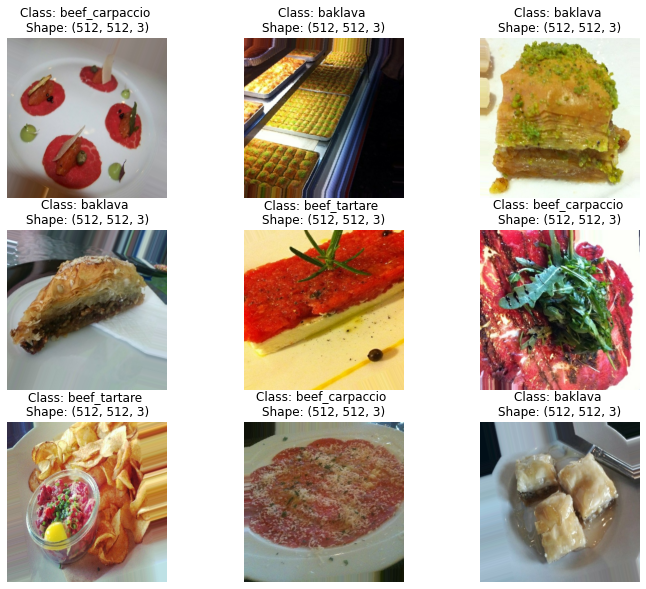

In [14]:
# visualize some data
plot_transfomed_images(train_set)

In [13]:
with strategy.scope():
    model = build_model((None, None, 3), N_CLASSES)

history = model.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, 
                    validation_data=valid_set, validation_steps=VALIDATION_STEPS, 
                   callbacks=[lr_callback])
model.evaluate(test_set, steps=TEST_STEPS)

71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
118/118 [==============================] - 325s 2s/step - loss: 4.6910 - sparse_categorical_accuracy: 0.0093 - val_loss: 4.6299 - val_sparse_categorical_accuracy: 0.0095
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.066666666666667e-05.
118/118 [==============================] - 176s 1s/step - loss: 4.6734 - sparse_categorical_accuracy: 0.0120 - val_loss: 4.2963 - val_sparse_categorical_accuracy: 0.2004
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00016033333333333335.
118/118 [==============================] - 177s 2s/step - loss: 4.3078 - sparse_categorical_accuracy: 0.0744 - val_loss: 2.3435 - val_sparse_categorical_accuracy: 0.4122
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00024.
118/118 [==============================] - 172s 1s/step - loss: 3.4803

[0.36731499433517456, 0.8980787992477417]

### Supervised Contrastive Learning

In [12]:
def get_encoder(input_shape):
    inputs = keras.Input(input_shape, name='inputs')
    base_model = efn.EfficientNetB4(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    model = Model(inputs=inputs, outputs=base_model.outputs)
    return model

def get_classifier(input_shape, encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(input_shape, name='inputs')
    features = encoder(inputs)
    dropout1 = keras.layers.Dropout(.5)(features)
    dense = keras.layers.Dense(1000, activation="relu")(dropout1)
    dropout2 = keras.layers.Dropout(.5)(dense)
    outputs = keras.layers.Dense(N_CLASSES, activation="softmax", dtype='float32')(dropout2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
    return model

temperature = 0.1

class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature
        
    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(input_shape, encoder):
    inputs = keras.layers.Input(shape=input_shape, name='inputs')
    features = encoder(inputs)
    outputs = keras.layers.Dense(128, activation='relu', name='projection_head', dtype='float32')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
print('Encoder pretraining using Supervised Contrastive Loss:')
with strategy.scope():
    encoder = get_encoder((None, None, 3))
    encoder_proj = add_projection_head((None, None, 3), encoder)

encoder_proj.compile(loss=SupervisedContrastiveLoss(temperature),
                        optimizer='adam')
history_enc = encoder_proj.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_SCL, 
                                validation_data=valid_set, validation_steps=VALIDATION_STEPS,
                                verbose=2, callbacks=[lr_callback])

print('Classifier training + frozen encoder:')
total_epochs = EPOCHS * STEPS_PER_EPOCH
with strategy.scope():
    classifier = get_classifier((None, None, 3), encoder)
        
classifier.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
    
history = classifier.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, 
                            validation_data=valid_set, validation_steps=VALIDATION_STEPS,
                            verbose=2, callbacks=[lr_callback])

classifier.evaluate(test_set, steps=TEST_STEPS)

Encoder pretraining using Supervised Contrastive Loss:
71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
118/118 - 322s - loss: 3.2663 - val_loss: 5.7048
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 8.066666666666667e-05.
118/118 - 173s - loss: 3.2691 - val_loss: 4.5423
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00016033333333333335.
118/118 - 178s - loss: 2.7989 - val_loss: 4.3967
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00024.
118/118 - 173s - loss: 2.6235 - val_loss: 4.3545
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001922.
118/118 - 181s - loss: 2.4620 - val_loss: 4.3299
Epoch 6/15

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00015396000000000002.
118/118 - 177s - loss: 2.3684 - val_loss: 4.2987
Epoch 7/15

Epoch 00007: LearningRateScheduler red

[0.37265804409980774, 0.8969228863716125]

In [15]:
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
test_embed, oof_preds = [], []
# merge training and validation filenames
TRAINING_FILENAMES.extend(VALIDATION_FILENAMES)

# inference dataset configuration
test_set = get_dataset(TEST_FILENAMES, ordered=True)
x_test = test_set.map(lambda image, label: image)
y_test = [label.numpy() for image, label in iter(test_set.unbatch())]
test_preds = np.zeros((NUM_TEST_IMAGES, N_CLASSES))

for n_fold, (tr_ind, val_ind) in enumerate(folds.split(TRAINING_FILENAMES)):
    if n_fold >= FOLDS_TO_USE:
        break
        
    print('FOLD {}'.format(n_fold + 1))
    tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    
    fold_tr_filenames = np.asarray(TRAINING_FILENAMES)[tr_ind]
    fold_val_filenames = np.asarray(TRAINING_FILENAMES)[val_ind]
    NUM_TR_IMG = count_data_items(fold_tr_filenames)
    STEPS_PER_EPOCH = NUM_TR_IMG // BATCH_SIZE
    
    # datasets
    train_set = get_dataset(fold_tr_filenames, repeated=True, augmentation=True, shuffle=True)
    valid_set = get_dataset(fold_val_filenames, ordered=True, cached=True)
    
    # initialize and train model
    print('Encoder pretraining using Supervised Contrastive Loss:')
    with strategy.scope():
        encoder = get_encoder((None, None, 3))
        encoder_proj = add_projection_head((None, None, 3), encoder)
        
    encoder_proj.compile(loss=SupervisedContrastiveLoss(temperature),
                        optimizer='adam')
    
    history_enc = encoder_proj.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_SCL,
                                   validation_data=valid_set, validation_steps=VALIDATION_STEPS,
                                  verbose=2, callbacks=[lr_callback]).history    
    
    print('Classifier training + frozen encoder:')
    with strategy.scope():
        classifier = get_classifier((None, None, 3), encoder)
        classifier.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
    
    history = classifier.fit(train_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, 
                            validation_data=valid_set, validation_steps=VALIDATION_STEPS,
                            verbose=2, callbacks=[lr_callback]).history
    model_path = 'model_{}.h5'.format(n_fold)
    classifier.save_weights(model_path)
    
    print('OOF accuracy: {0:.3f}'.format(np.max(history['val_sparse_categorical_accuracy'])))
    
    # Inference
    test_preds += classifier.predict(x_test) / FOLDS_TO_USE
    test_embed.append(encoder.predict(x_test))
    
test_preds = np.argmax(test_preds, axis=-1)

FOLD 1
Encoder pretraining using Supervised Contrastive Loss:
71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
118/118 - 326s - loss: 4.2117 - val_loss: 5.7620
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 8.066666666666667e-05.
118/118 - 175s - loss: 3.2767 - val_loss: 4.5896
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00016033333333333335.
118/118 - 174s - loss: 2.8221 - val_loss: 4.4391
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00024.
118/118 - 175s - loss: 2.6395 - val_loss: 4.3728
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001922.
118/118 - 173s - loss: 2.4797 - val_loss: 4.3359
Epoch 6/15

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00015396000000000002.
118/118 - 176s - loss: 2.3809 - val_loss: 4.3183
Epoch 7/15

Epoch 00007: LearningRateSchedu

In [16]:
print(classification_report(y_test, test_preds, target_names=CLASSES))

                         precision    recall  f1-score   support

              apple_pie       0.88      0.67      0.76       250
         baby_back_ribs       0.89      0.94      0.91       250
                baklava       0.89      0.96      0.92       250
         beef_carpaccio       0.94      0.96      0.95       250
           beef_tartare       0.92      0.84      0.88       250
             beet_salad       0.89      0.83      0.86       250
               beignets       0.90      0.93      0.92       250
               bibimbap       0.96      0.96      0.96       250
          bread_pudding       0.78      0.79      0.78       250
      breakfast_burrito       0.86      0.88      0.87       250
             bruschetta       0.91      0.85      0.88       250
           caesar_salad       0.94      0.92      0.93       250
                cannoli       0.96      0.98      0.97       250
          caprese_salad       0.92      0.94      0.93       250
            carrot_cake 

In [17]:
classifier.evaluate(test_set)

50/50 [==============================] - 16s 290ms/step - loss: 0.3688 - sparse_categorical_accuracy: 0.8953


[0.368780255317688, 0.8952871561050415]